# Pricing European Options via Monte Carlo

### Assumptions
1. A constant risk-free rate with no correlation to the underlying
2. Geometric Brownian Motion as the stochastic process
3. A jump-free underlying evolution process
4. No additional discount factors (dividends etc.)

# Vanilla European Option Pricing
* Fundamentally, all assets drift at the riskless short-rate - otherwise arbitrage opportunities exist.
* The payoff of a European option is ${h(S_{T} \equiv max(S_{T} - K, 0)}$
* A stochastic pricer for this risk-neutral expectation is ${C_{0} = e^{-rT} E_{0}^{Q}(h(S_{T}) = e^{-rT} \int_{0}^{\infty} h(s) q(s) ds}$ with ${q(s)}$ as a P-equivalent risk-neutral probability measure
* Intuitively, the area under the 0-bounded curve of the security times a volatility process discounted to be risk-neutral
* Analytically, a Risk-neutral Monte Carlo estimator is ${\tilde{C_{0}} = e^{-rT} \sum_{1}^{I} h(S_{T}^{i})}$ with ${h(S_{T}^{i})}$ here as a stochastic security process

# Lookback Option Pricing
* These instruments are barely options, behaving more like a structured total return swap
* In a **floating strike lookback option**, the call version sets the strike as the minimum price of the underlying during the options life - while the put sets the strike as the maximum option.
* In a **fixed strike lookback option**, the payoff is the *maximum difference between the underlying's evolution and the fixed strike.*


# Asian Option Pricing
* An Asian option introduces the a term based on the average (arithmetic) price of the underlying over the life of the option. The payoff profiles are as follows:
1. Fixed Asian Call: ${C(T) = max(A(0, T) - K, 0)}$ 
2. Fixed Asian Put: ${P(T) = max(K - A(0, T), 0)}$
3. Float Asian Call: ${C(T) = max(S(T) - A(0, T), 0)}$
4. Float Asian Put: ${P(T) = max(A(0, T) - K, 0)}$

In [65]:
import numpy as np
import math
from pylab import plt, mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

In [24]:
class Helpers:
    def generate_var_reduced_random(partitions, trials):
        sn = np.random.standard_normal((partitions + 1, trials))
        return (sn - sn.mean()) / sn.std()

In [197]:
class MarketState:
    
    def __init__(self, time, S0, r, sigma, option_type='vanilla'):
        self.time = time # Option time until expiry (in years)
        self.S0 = S0 # Security price at t0
        self.sigma = sigma # Security volatility
        self.r = r # Constant risk-free rate
        self.option_type = option_type # of vanilla, lookback, Asian
    

    def european_monte_carlo_valuation(self, trials, partitions, strike, call_put):
        dt = self.time / partitions
        S = np.zeros((partitions + 1, trials))
        underlying_maximum = np.zeros((partitions + 1, trials))
        underlying_minimum = np.zeros((partitions + 1, trials))
        underlying_avg = np.zeros((partitions + 1, trials))
        S[0] = self.S0
        random_mesh = Helpers.generate_var_reduced_random(partitions, trials) # Gaussian normalized random numbers
        for t in range(1, partitions+1):
            # Run stochastic process
            S[t] = S[self.time-1] * np.exp((self.r - 0.5 * self.sigma ** 2) * dt + self.sigma * math.sqrt(dt) * random_mesh[t]) 
            underlying_maximum[t] = S[t].max()
            underlying_minimum[t] = S[t].min()
            underlying_avg[t] = S[t].mean()
        if self.option_type == 'vanilla':
            if call_put =='call':
                hT = np.maximum(S[-1] - strike, 0)
            if call_put == 'put':
                hT = np.maximum(strike - S[-1], 0) 
        if self.option_type == 'lookback_float':
            if call_put =='call':
                strike = underlying_minimum[-1]
                hT = np.maximum(S[-1] - strike, 0)
            if call_put == 'put':
                strike = underlying_maximum[-1]
                hT = np.maximum(strike - S[-1], 0) 
        if self.option_type == 'lookback_fixed':
            if call_put =='call':
                lc = underlying_maximum[-1] - strike
                hT = np.maximum(lc, 0)
            if call_put =='put':
                lp = strike - underlying_minimum[-1]
                hT = np.maximum(lp, 0)
        # TODO Asian
        if self.option_type == 'asian_fixed':
            if call_put =='call':
                hT = np.maximum(underlying_avg[-1] - strike, 0)
            if call_put == 'put':
                hT = np.maximum(strike - underlying_avg[-1], 0) 
        if self.option_type == 'asian_float':
            if call_put =='call':
                strike = underlying_minimum[-1]
                hT = np.maximum(S[-1] - underlying_avg[-1], 0)
            if call_put == 'put':
                strike = underlying_maximum[-1]
                hT = np.maximum(underlying_avg[-1] - S[-1], 0) 
        
        C0 = math.exp(-self.r * self.time) * np.mean(hT) # Risk neutral mean of trials
        return S, hT, C0 # Evolution process of underlying, option values, Monte Carlo mean

In [77]:
tsla = MarketState(1, 1378., 0.02, .6) # Set up some market facts for TSLA
S, hT, C0 = tsla.european_monte_carlo_valuation(10000, 50, 400, 'call') # Dramatically in the money
S, hT, C1 = tsla.european_monte_carlo_valuation(10000, 50, 1600, 'call') # Dramatically in the money
S, hT, C2 = tsla.european_monte_carlo_valuation(10000, 50, 1400, 'call') # Dramatically in the money
print(f'ITM: {C0: .4f}')
print(f'OOTM: {C1:.4f}') 
print(f'Near the Money: {C2:.4f}')

ITM:  961.4621
OOTM: 1.8891
Near the Money: 36.7345


In [86]:
def generate_european_price_surface(market_state, strikes, option):
    price_mean = []
    for K in strikes:
        process, option_trials, mean_strike = tsla.european_monte_carlo_valuation(10000, 50, K, option)
        price_mean.append(mean_strike)
    return price_mean

In [62]:
tsla = MarketState(1, 1378., 0.02, .6)
strike_list = np.arange(800., 1900, 5.)
call_surface = generate_european_price_surface(tsla, strike_list, 'call')
call_surface = np.array(call_surface)

Text(0, 0.5, 'Option Value')

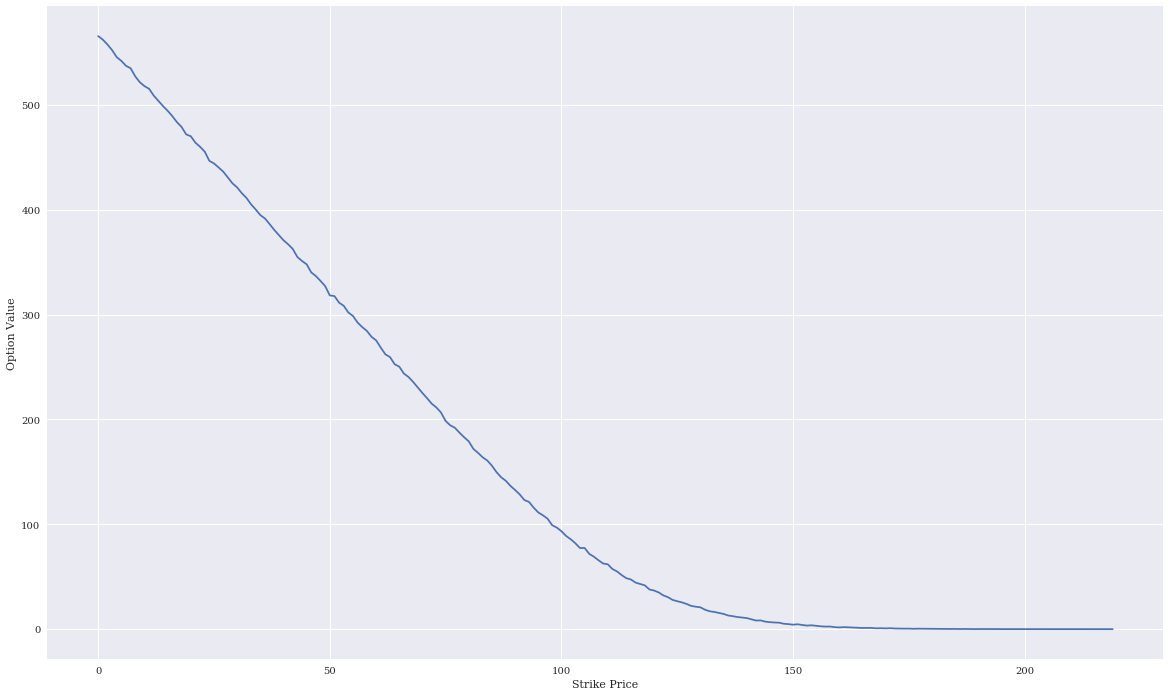

In [68]:
plt.figure(figsize=(20,12))
plt.plot(call_surface)
plt.xlabel('Strike Price')
plt.ylabel('Option Value')

(array([  1.,   0.,   1.,   5.,   4.,   8.,  18.,  29.,  42.,  63., 109.,
        145., 237., 277., 357., 392., 471., 556., 570., 585., 636., 636.,
        627., 594., 567., 497., 463., 395., 332., 288., 259., 184., 162.,
        126.,  97.,  72.,  56.,  38.,  33.,  21.,  10.,  11.,   8.,   8.,
          3.,   4.,   1.,   0.,   0.,   2.]),
 array([  0.        ,  19.2815787 ,  38.56315739,  57.84473609,
         77.12631479,  96.40789349, 115.68947218, 134.97105088,
        154.25262958, 173.53420827, 192.81578697, 212.09736567,
        231.37894436, 250.66052306, 269.94210176, 289.22368046,
        308.50525915, 327.78683785, 347.06841655, 366.34999524,
        385.63157394, 404.91315264, 424.19473133, 443.47631003,
        462.75788873, 482.03946743, 501.32104612, 520.60262482,
        539.88420352, 559.16578221, 578.44736091, 597.72893961,
        617.0105183 , 636.292097  , 655.5736757 , 674.8552544 ,
        694.13683309, 713.41841179, 732.69999049, 751.98156918,
        771.263147

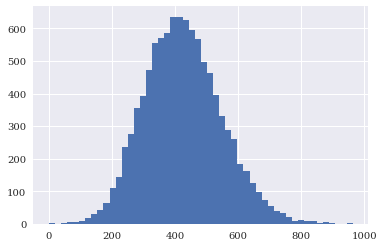

In [118]:
tsla = MarketState(1, 1378., 0.02, .62, option_type='lookback_float') # Floating lookback call
S, hT, C4 = tsla.european_monte_carlo_valuation(10000, 50, 1378, 'call')
# Value of Lookback Float normally distributed, as expected
plt.hist(hT, bins=50)

In [180]:
tsla = MarketState(1, 1378., 0.02, .62, option_type='lookback_fixed') # Fixed lookback call
S, hT, C5 = tsla.european_monte_carlo_valuation(10000, 50, 1378, 'call')
C5

513.619514637086

In [192]:
tsla = MarketState(1, 1378., 0.02, .62, option_type='lookback_float') # Float lookback call
S, hT, C6 = tsla.european_monte_carlo_valuation(10000, 50, 1378, 'call')
C6

358.12308201515106

In [257]:
tsla = MarketState(1, 1378., 0.02, .62, option_type='asian_fixed') # Asian Fixed Call
S, hT, C7 = tsla.european_monte_carlo_valuation(10000, 50, 800., 'call')
C7

569.6680375176416

In [258]:
tsla = MarketState(1, 1378., 0.02, .62, option_type='asian_float') # Asian Floating Put
S, hT, C7 = tsla.european_monte_carlo_valuation(10000, 50, 1400., 'put')
C7

46.97219695697765